In [22]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

In [23]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211108-100x-reuseevq-pyopt-8corespernode-100gbit"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = timedir.split("_")[3].replace("nodes","")
    chunks = timedir.split("_")[2].replace("chunks","")
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = f.split("_")[1].replace("task","")
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,26.208,6525388296,2163,14117594700,4,1,8
1,24.636,8257431530,1709,14117594700,4,1,8
2,25.874,8291180109,1702,14117594700,4,1,8
3,24.347,8726767389,1617,14117594700,4,1,8
4,25.613,6848909934,2061,14117594700,4,1,8
...,...,...,...,...,...,...,...
1507,5.863,5292594439,444,2352932472,7,6,48
1508,5.868,5257568882,447,2352932472,7,6,48
1509,5.907,5044214402,466,2352932472,7,6,48
1510,5.904,5400764270,435,2352932472,17,6,48


In [24]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,8,26.040111,8.520682e+09,1708.805556,1.411759e+10,3.5,1.0
1,16,13.093826,6.867615e+09,1049.743056,7.058797e+09,7.5,2.0
2,24,9.177435,6.852074e+09,696.060185,4.705865e+09,11.5,3.0
3,32,7.221069,6.009454e+09,590.062500,3.529399e+09,15.5,4.0
4,40,5.975981,5.074893e+09,558.188889,2.823519e+09,19.5,5.0
5,48,5.811630,5.162829e+09,455.675926,2.352932e+09,23.5,6.0


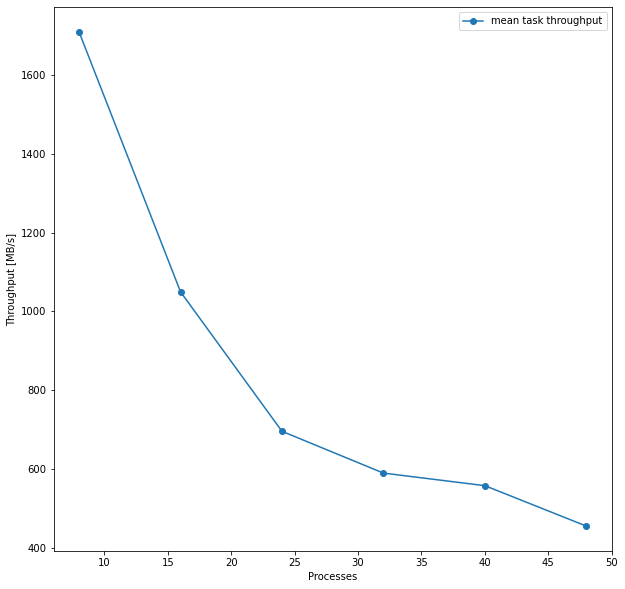

In [25]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [26]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput
0,8,1,28,208.320889,6.816546e+10,13670.444444,1.129408e+11,13.350043
1,16,2,120,209.501222,1.098818e+11,16795.888889,1.129408e+11,16.402235
2,24,3,276,220.258444,1.644498e+11,16705.444444,1.129408e+11,16.313911
3,32,4,496,231.074222,1.923025e+11,18882.000000,1.129408e+11,18.439453
4,40,5,780,239.039222,2.029957e+11,22327.555556,1.129408e+11,21.804253
5,48,6,1128,278.958222,2.478158e+11,21872.444444,1.129408e+11,21.359809


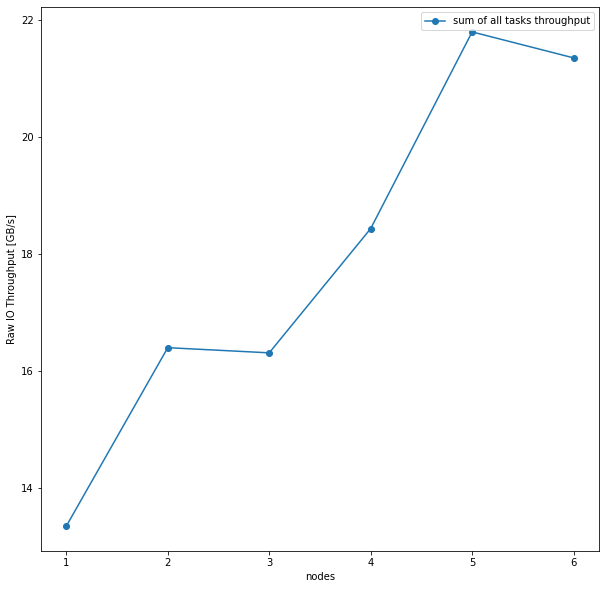

In [32]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="sum of all tasks throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Raw IO Throughput [GB/s]")
pyplot.legend()

# Python timer

In [28]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_MB_s":[]}
timedir = "20211108-100x-reuseevq-pyopt-8corespernode-100gbit/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = readpercent * datasetsize

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_MB_s"].append(round(readsize/time_mean/1024/1024))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_MB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_MB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_MB_s,runtimespeedup,throughputspeedup
0,1,28.81,0.39,4142,1.000000,1.000000
1,2,14.65,0.19,8142,1.966553,1.965717
2,3,10.20,0.14,11700,2.824510,2.824722
3,4,8.10,0.10,14724,3.556790,3.554804
4,5,6.62,0.06,18020,4.351964,4.350555
5,6,6.33,0.03,18856,4.551343,4.552390


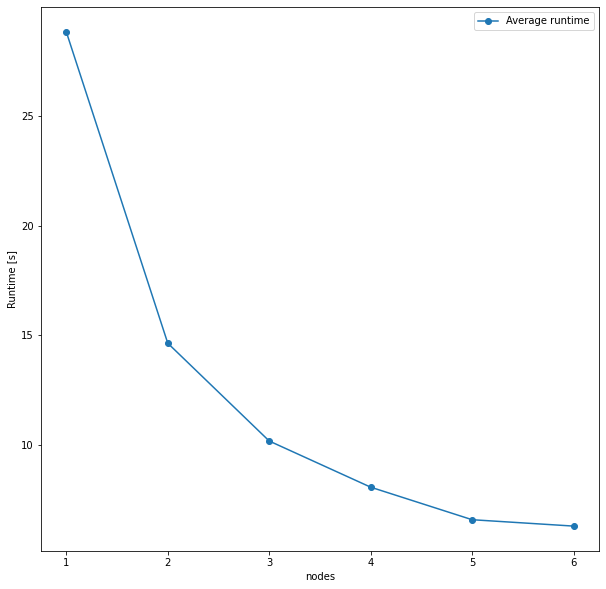

In [29]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

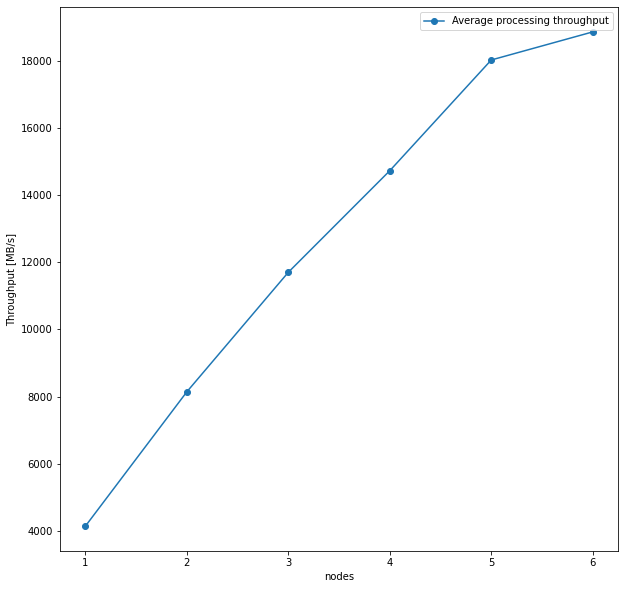

In [30]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_MB_s"], label="Average processing throughput", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

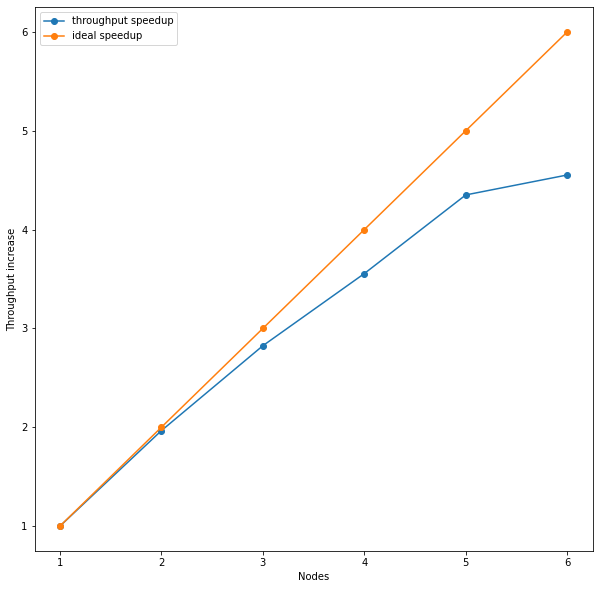

In [31]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput speedup", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal speedup", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput increase")
pyplot.legend()